<a href="https://colab.research.google.com/github/Bollash/Entity-recognition-hw/blob/main/Entity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install transformers

In [ ]:
import pandas as pd
import urllib.request
import gzip
import shutil
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer

In [ ]:
#Downloading the dataset.
url = "http://hlt.sztaki.hu/resources/hunnerwiki/huwiki.1.ner.tsv.gz"
local_file = "data.tsv.gz"
urllib.request.urlretrieve(url, local_file)

('data.tsv.gz', <http.client.HTTPMessage at 0x7f3de3a01a50>)

In [ ]:
#Decompressing the data
with gzip.open(local_file, 'rb') as f_in:
    with open('file.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [ ]:
#Loading the data into data_set. There are lines that produce errors. We filter them out by using the third parameter
data_set = pd.read_csv('file.tsv', sep='\t', error_bad_lines=False)

b'Skipping line 121529: expected 6 fields, saw 16498\nSkipping line 121533: expected 6 fields, saw 10\nSkipping line 121537: expected 6 fields, saw 8198\n'


In [ ]:
data_set.head

<bound method NDFrame.head of                      A  text  0                           ART             a  O
0               céljuk  text  0              NOUN<POSS<PLUR>>           cél  O
1                    ,  text  0                         PUNCT             ,  O
2                 hogy  text  0                          CONJ          hogy  O
3          biztosítsák  text  0  VERB<SUBJUNC-IMP><PLUR><DEF>      biztosít  O
4                    ,  text  0                         PUNCT             ,  O
...                ...   ... ..                           ...           ... ..
2237028            280  text  0                           NUM           280  O
2237029           km/h  text  0                          NOUN          km/h  O
2237030              a  text  0                           ART             a  O
2237031  végsebbessége  text  0                    NOUN<POSS>  végsebbesség  O
2237032              .  text  0                         PUNCT             .  O

[2237033 rows x 6 col

In [ ]:
#Drop the empty lines
data_set = data_set.dropna()

In [ ]:
smaller = data_set[['A','O']]
#Using a fraction of the original data since there are 2.3 million elements.
smaller = smaller[0:200000]
#Some lines are NaN. We filter them out this way.
smaller = smaller[smaller['O'].notnull()]

In [ ]:
#To convert the tags into numbers we'll use a dictionary. Currently there is no 'PAD', but we shall add them later.
d = {
    'B-LOC' : 0,
    'B-MISC' : 1,
    'B-ORG' : 2,
    'B-PER' : 3,
    'I-LOC' : 4,
    'I-MISC' : 5,
    'I-ORG' : 6,
    'I-PER' : 7,
    'O' : 8,
    'PAD' : 9,
    'BOS' : 10,
    'EOS' : 11
}
#Converting the tags
for idx, row in smaller.iterrows():
  row[1] = d[row[1]]

In [ ]:
#Reconstructing the sentences.

#Used to filter out punctuation.
garbage = {'.', ',', '\"', "\'", '/', '\\', '(', ')', '\'', ':', '?', '!', '’', '-', ';'}
sentences = []
y_sentences = []
sent = []
y_sent = []
for idx, row in smaller.iterrows():
  #Theese characters mark the end of a sentence.
  if row[0] in {'.', '?', '!', ':'}:
    sentences.append(sent)
    sent = []
    y_sentences.append(y_sent)
    y_sent = []
    continue
  if row[0] not in garbage:
    sent.append(row[0])
    y_sent.append(row[1])
  

In [ ]:
sentences[0], y_sentences[0]

(['céljuk',
  'hogy',
  'biztosítsák',
  'hogy',
  'a',
  'korábbi',
  'szerzők',
  'kilétét',
  'hozzájárulásának',
  'mértékét',
  'a',
  'művel',
  'kapcsolatos',
  'üzleti',
  'jogi',
  'politikai',
  'erkölcsi',
  'vagy',
  'filozófiai',
  'álláspontját',
  'ne',
  'lehessen',
  'eltitkolni',
  'vagy',
  'meghamisítani',
  'a',
  'későbbi',
  'változtatások',
  'során'],
 [8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8])

In [ ]:
#We're usning hubert base cc tokenizer
tokenizer = AutoTokenizer.from_pretrained("SZTAKI-HLT/hubert-base-cc")

def tokenize_sentence(sentence, tokenizer):
  tokenized = []
  for word in sentence:
    tokenized.append(tokenizer.tokenize(word))
  return tokenized

In [ ]:
#Tokenize the input sentences.
#We can't use the lemmas because Budapest is an entity but budapesti isn't.
#This makes it, that most of our words consist of 1 tokens.

max_word_len = 0
tokenized_sentences = []
for sent in sentences:
  tokenized_sent = tokenize_sentence(sent, tokenizer)
  for tok_word in tokenized_sent:
    max_word_len = max(max_word_len, len(tok_word))
  tokenized_sentences.append(tokenized_sent)

In [ ]:
#Inserting a BOS(beginning of sentence) and EOS(end of sentence) token. It's needed for the ngrams.
for sentence in tokenized_sentences:
  sentence.insert(0, ['BOS'])
  sentence.append(['EOS'])
#Inserting BOS and EOS values to the output values aswell
for y in y_sentences:
  y.insert(0, 10)
  y.append(11)

#Padding the sentences
for sentence in tokenized_sentences:
  for word in sentence:
    for _ in range(max_word_len - len(word)):
      word.append('PAD')

In [ ]:
tokenized_sentences[0]

[['BOS',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['céljuk',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['hogy',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['biztosít',
  '##sák',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['hogy',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['a',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['korábbi',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD'],
 ['szerzők',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  'PAD',
  '

In [ ]:
#Instead of the sentences we use ngrams. It makes it so theres less padding needed, and also we can use ngram based accuracy.

def make_ngrams(sentence, n):
  ngrams = []
  for i in range(len(sentence) - n + 1):
    ngram = []
    for j in range(n):
      ngram.append(sentence[i + j])
    ngrams.append(ngram)
  return ngrams

In [ ]:
#Currently using bigramms, but it can be changed upwards if needed.
ngram_size = 2
ngrams = []
for sentence in tokenized_sentences:
  ngrams.append(make_ngrams(sentence, ngram_size))

#When we convert to ngrams, theres one less ngram than the input size. So we need to cut the last output element.
for y_sentence in y_sentences:
  for _ in range(ngram_size - 1):
    y_sentence.pop()

In [ ]:
ngrams[0]

[[['BOS',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD'],
  ['céljuk',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD']],
 [['céljuk',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD'],
  ['hogy',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD']],
 [['hogy',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD'],
  ['biztosít',
   '##sák',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD']],
 [['biztosít',
   '##sák',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',
   'PAD',

In [ ]:
#One-Hot encode our tags
for i in range(len(y_sentences)):
  y_sentences[i] = to_categorical(y_sentences[i], 12)

In [ ]:
y_sentences[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.,

In [ ]:
#Flatten our data, so it's easier to work with.

x_ngrams = []
for sentence in ngrams:
  for ngram in sentence:
    x = []
    for word in ngram:
      for token in word:
        x.append(token)
    x_ngrams.append(x)

y_ngrams = []
for sentence in y_sentences:
  for ngram in sentence:
    y_ngrams.append(ngram)

In [ ]:
x_ngrams[0]

['BOS',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'céljuk',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [ ]:
#We use a BoW(bag of words) method for the word to number conversion. An embedding layer could be used instead if we need a better accuracy.

#Filling our vocab with the tokens.
#Currently even the test data is put into it. It would be better no not include them and make an universal number for the tokens that are not inculded in the vocab.
vocab, index = {}, 1  # start indexing from 1
vocab['PAD'] = 0  # add a padding token
for word in x_ngrams:
  for token in word:
    if token not in vocab:
      vocab[token] = index
      index += 1


vocab_size = len(vocab)
print(vocab)

{'PAD': 0, 'BOS': 1, 'céljuk': 2, 'hogy': 3, 'biztosít': 4, '##sák': 5, 'a': 6, 'korábbi': 7, 'szerzők': 8, 'kil': 9, '##ét': 10, 'hozzájárulás': 11, '##ának': 12, 'mértékét': 13, 'művel': 14, 'kapcsolatos': 15, 'üzleti': 16, 'jogi': 17, 'politikai': 18, 'erkölcsi': 19, 'vagy': 20, 'filozófiai': 21, 'álláspontját': 22, 'ne': 23, 'lehessen': 24, 'elt': 25, '##itk': 26, '##olni': 27, 'megh': 28, '##amis': 29, '##ítani': 30, 'későbbi': 31, 'változtatás': 32, '##ok': 33, 'során': 34, 'EOS': 35, 'Figyelem': 36, 'Mivel': 37, 'nem': 38, 'jogász': 39, 'által': 40, 'készített': 41, 'hiteles': 42, 'fordítás': 43, 'szempontból': 44, 'csak': 45, 'az': 46, 'eredeti': 47, 'angol': 48, 'nyelvű': 49, 'licenc': 50, 'mér': 51, '##vad': 52, '##ó': 53, 'Az': 54, '1': 55, '.': 56, '2': 57, 'változat': 58, 'különbség': 59, 'pedig': 60, 'címen': 61, 'található': 62, 'Jelen': 63, 'célja': 64, 'egy': 65, 'olyan': 66, 'kézikönyv': 67, 'tankönyv': 68, 'eff': 69, '##ajt': 70, '##a': 71, 'írott': 72, 'dokumentum':

In [ ]:
#Converting our input into integers, with our BoW vocab.

embedded_x_ngrams = []
for ngram in x_ngrams:
  embedded_x_ngram = []
  for token in ngram:
    embedded_x_ngram.append(vocab[token])
  embedded_x_ngrams.append(embedded_x_ngram)

In [ ]:
#Converting the lists into Numpy arrays
sentences = np.array(embedded_x_ngrams)
y_sentences = np.array(y_ngrams)

In [ ]:
#Split the data into train, test, and val data
#train : 0.6
#test : 0.2
#val: 0.2
#Since the train test split splits the data into 2 parts we have to call it twice
x_train, x_test, y_train, y_test = train_test_split(sentences, y_sentences, test_size=0.2, random_state=123)
#We need test_size=0.25 since 0.2 / 0.8 == 0.25
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=123)

In [ ]:
# Saving datasets for optimization
np.savetxt('x_train.txt', x_train)
np.savetxt('y_train.txt', y_train)
np.savetxt('x_val.txt', x_val)
np.savetxt('y_val.txt', y_val)

In [ ]:
y_sentences[1], sentences[1]

(array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import keras.backend as K
import sklearn
class CustomAccuracy(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    difference = y_pred-y_true
    weight = tf.constant([10.0,10,10,10,10,10,10,10,1,1,1,1])
    result = tf.multiply(difference, weight)
    return tf.reduce_sum(tf.square(result))

In [ ]:
y_pred=tf.zeros([12])
y_true=tf.ones([12])

In [ ]:
difference = y_pred-y_true
weight = tf.constant([10.0,10,10,10,10,10,10,10,1,1,1,1])
result = tf.multiply(difference, weight)
tf.reduce_mean(tf.square(result))

<tf.Tensor: shape=(), dtype=float32, numpy=3334.0>

In [ ]:
class CustomAccuracy(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred-y_true))
    rmse = tf.math.sqrt(mse)
    return rmse / tf.reduce_mean(tf.square(y_true)) - 1

In [ ]:
input_shape = (28,)
max_features = vocab_size+1
inputs = keras.Input(shape=input_shape, dtype="int32")

x = layers.Embedding(max_features, 128)(inputs)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(12, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 28, 128)           2524928   
                                                                 
 bidirectional_4 (Bidirectio  (None, 28, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 12)                1548      
                                                                 
Total params: 2,724,108
Trainable params: 2,724,108
Non-tra

In [ ]:
model.compile("adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
history=model.fit(x_train, y_train, batch_size=256, epochs=1, validation_data=(x_val, y_val))

427/427 [==============================] - 168s 380ms/step - loss: 0.1854 - accuracy: 0.9638 - val_loss: 0.0586 - val_accuracy: 0.9862


In [ ]:
inverse_vocab={}
for key, value in vocab.items():
  inverse_vocab[value]=key

In [ ]:
np.asarray([x_test[340]])

array([[ 3341,  8042,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 10066,   433,  1010,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])

In [ ]:
prediction = model.predict(x_test)
prediction

array([[9.12658561e-06, 4.67700920e-05, 1.12375565e-05, ...,
        4.94793085e-07, 2.22405589e-07, 2.29316953e-07],
       [1.58070579e-05, 6.75345436e-05, 2.03106429e-05, ...,
        7.68423661e-07, 4.12429358e-07, 3.59723884e-07],
       [1.55622220e-05, 6.77440257e-05, 1.99976912e-05, ...,
        7.63619312e-07, 4.03754541e-07, 3.55749194e-07],
       ...,
       [1.07160467e-05, 5.22072951e-05, 1.33826234e-05, ...,
        5.65588778e-07, 2.66442612e-07, 2.62244271e-07],
       [1.76093326e-05, 7.67218735e-05, 2.28670870e-05, ...,
        8.49049854e-07, 4.59137112e-07, 3.96114359e-07],
       [2.32971397e-05, 9.70890105e-05, 3.09997740e-05, ...,
        1.06476136e-06, 6.23078563e-07, 5.00629028e-07]], dtype=float32)

In [ ]:
inverse_vocab[x_test[296][5]]

'PAD'

In [ ]:
y_test[95]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
x_indices=[i for i in range(len(prediction)) if np.argmax(prediction[i]) not in range(8,12)]

In [ ]:
x_indices[100:112]

[5085, 5094, 5214, 5251, 5258, 5270, 5316, 5344, 5387, 5417, 5444, 5467]

In [ ]:
indices=[idx for idx in range(len(y_test)) if np.sum(y_test[idx][:8])!=0]

In [ ]:
indices[100:112]

[5085, 5094, 5214, 5251, 5265, 5270, 5329, 5344, 5345, 5387, 5417, 5444]

In [ ]:
prediction=np.asarray([prediction[i] for i in good_indices])

In [ ]:
summation=0
length=max(np.max(x_indices),np.max(indices))
good_indices=[]
for i in range(length):
  if i in x_indices and i in indices: 
    summation+=1
    good_indices.append(i)
summation/=len(indices)
summation

0.845925925925926

In [ ]:
x_test[95]

array([ 4037,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 13951,   287,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [ ]:
def compare(pred, origi):
  return np.argmax(pred) == np.argmax(origi)

In [ ]:
#Checking the accuracy on the test data
correct_predictions = 0
for i in range(len(prediction)):
  if(compare(prediction[i], y_test[i])):
    correct_predictions += 1

print(f"Accuracy on the test data is: {correct_predictions / len(prediction):.4f}%")

Accuracy on the test data is: 0.0504%


In [ ]:
%tensorflow_version 2.x 

In [ ]:
!pip3 install hyperas
!pip3 install hyperopt

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
# Optimization: we need to load the data and create models
def data():
  x_train=np.loadtxt('x_train.txt')
  y_train=np.loadtxt('y_train.txt')
  x_val=np.loadtxt('x_val.txt')
  y_val=np.loadtxt('y_val.txt')
  return x_train, y_train, x_val, y_val

In [ ]:
def create_model(x_train, y_train, x_val, y_val):

    # These are the hyperparameters we analyze
    n_layer1 = {{choice([64, 128, 256, 512])}}
    n_layer2 = {{choice([64, 128, 256, 512])}}
    n_layer3 = {{choice([64, 128, 256, 512])}}
    optim = {{choice(['rmsprop', 'adam', 'sgd'])}}
    n_batch = {{choice([32, 64, 128, 256])}}
    print('Hyperparameters of the model: ', n_layer1, n_layer2, n_layer3, optim, n_batch)

    input_shape = (28,)
    max_features = 19725
    inputs = keras.Input(shape=input_shape, dtype="int32")

    x = layers.Embedding(max_features, n_layer1)(inputs)

    x = layers.Bidirectional(layers.LSTM(n_layer2, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(n_layer3))(x)

    outputs = layers.Dense(12, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(optimizer=optim,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, verbose=0)]

    result = model.fit(x_train, y_train,
              batch_size=n_batch,
              epochs=100,
              verbose=2,
              validation_data=(x_val, y_val),
              callbacks=callbacks,
              shuffle=True)
    
    # Get the highest validation accuracy of the training epochs
    best_val_acc = np.amax(result.history['val_accuracy']) 
    print('Best val_acc:', best_val_acc,'\n')
    

    # Print log - structure of the network and the result
    with open('hyperas-entity_recog-log.csv', 'a') as csv_file:
      csv_file.write(str(n_layer1) + ';')
      csv_file.write(str(n_layer2) + ';')
      csv_file.write(str(n_layer3) + ';')
      csv_file.write(str(optim) + ';')
      csv_file.write(str(n_batch) + ';')
      csv_file.write(str(best_val_acc) + '\n')

    return {'loss': -best_val_acc, 'status': STATUS_OK, 'model': model}

In [ ]:
with open('hyperas-entity_recog-log.csv', 'w') as csv_file:
      csv_file.write('n_layer1' + ';')
      csv_file.write('n_layer2' + ';')
      csv_file.write('n_layer3' + ';')
      csv_file.write('optim' + ';')
      csv_file.write('n_batch' + ';')
      csv_file.write('best_val_acc' + '\n')

In [ ]:
# After this, we have to download the notebook from colab
# and upload the .ipynb file in the actual folder

In [ ]:
import hyperas
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice

In [ ]:
# Start hyperparameter optimization
best_run, best_model = optim.minimize(model=create_model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=3,
                                          notebook_name='Entity_recognition',
                                          trials=Trials())

>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import urllib.request
except:
    pass

try:
    import gzip
except:
    pass

try:
    import shutil
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    from tensorflow.keras.utils import to_categorical
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from transformers import AutoTokenizer
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from tensorflow import keras
except:
    pass

try:
    from tensorflow.keras import layers
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    import hyperas
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice
except:
    pass

try:
    import pandas
except:
    pass

try:
    impo

In [ ]:
print("Evaluation of the best model:")
print(best_model.evaluate(x_test, y_test))
print("Best hyperparameters:")
print(best_run)

Evaluation of the best model:
1138/1138 [==============================] - 29s 24ms/step - loss: 0.0578 - accuracy: 0.9868
[0.05776441842317581, 0.9867842793464661]
Best hyperparameters:
{'n_batch': 3, 'n_layer1': 0, 'n_layer1_1': 2, 'n_layer1_2': 2, 'optim': 1}


In [ ]:
import pandas
# Print structure of the models and the results
df = pandas.read_csv('hyperas-entity_recog-log.csv', delimiter=';')
df.sort_values(by=['best_val_acc'], ascending=False)

,n_layer1,n_layer2,n_layer3,optim,n_batch,best_val_acc
2,64,256,256,adam,256,0.988186
1,64,128,256,rmsprop,128,0.985383
0,256,64,128,sgd,256,0.910650


In [ ]:
# Best models
hyperas_best = df.sort_values(by=['best_val_acc'], ascending=False).head(n=2)
# Worst models
hyperas_worst = df.sort_values(by=['best_val_acc'], ascending=False).tail(n=2)

In [ ]:
import matplotlib.pyplot as plt

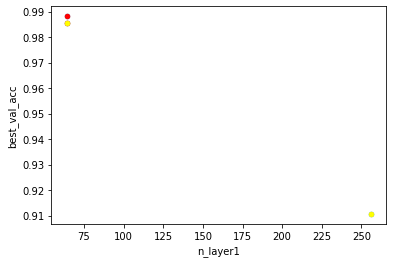

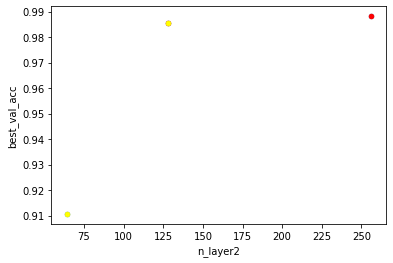

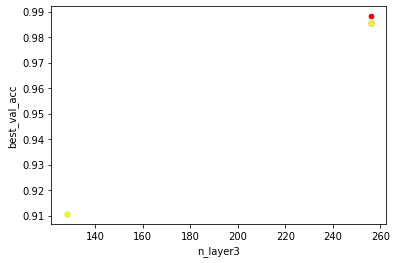

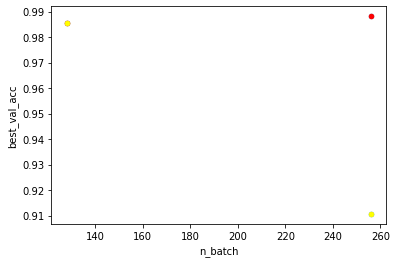

In [ ]:
for hyperparam in ['n_layer1', 'n_layer2', 'n_layer3', 'n_batch']:
  ax1 = df.plot(kind='scatter', x=hyperparam, y='best_val_acc')
  hyperas_best.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='red', ax=ax1)
  hyperas_worst.plot(kind='scatter', x=hyperparam, y='best_val_acc', color='yellow', ax=ax1)

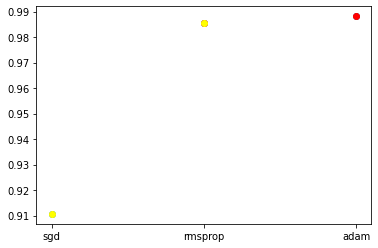

In [ ]:
plt.scatter(df.optim, df.best_val_acc)
plt.scatter(hyperas_best.optim, hyperas_best.best_val_acc, color='red')
plt.scatter(hyperas_worst.optim, hyperas_worst.best_val_acc, color='yellow')
plt.show()

In [ ]:
import seaborn as sns

(2.5, -0.5)

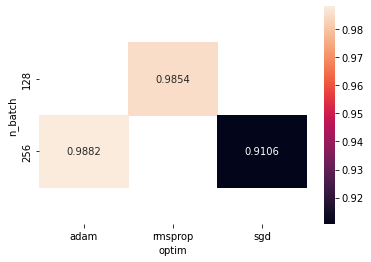

In [ ]:
max_val_acc = df.groupby(['n_batch', 'optim']).max()
max_val_acc = max_val_acc.unstack()[['best_val_acc']]
sns.heatmap(max_val_acc.best_val_acc, annot=True, fmt='.4g');

b, t = plt.ylim() # Discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # Update the ylim(bottom, top) values

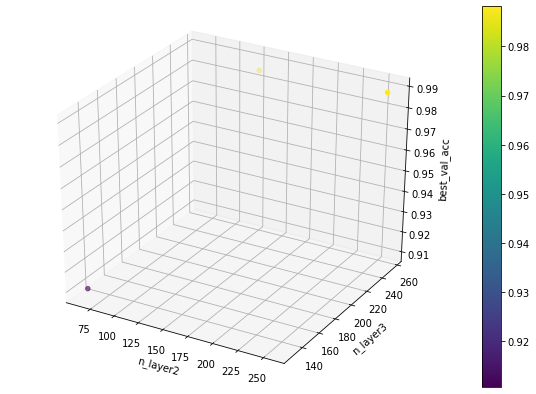

In [ ]:
# n_layer2 / n_layer3
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df.n_layer2, df.n_layer3, df.best_val_acc, c=df.best_val_acc)
ax.set_xlabel('n_layer2')
ax.set_ylabel('n_layer3')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

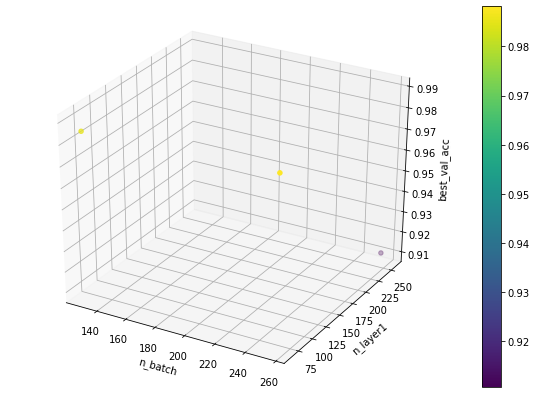

In [ ]:
# n_batch / n_layer1
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter3D(df.n_batch, df.n_layer1, df.best_val_acc, c=df.best_val_acc)
ax.set_xlabel('n_batch')
ax.set_ylabel('n_layer1')
ax.set_zlabel('best_val_acc')
fig.colorbar(p)
plt.show()

In [ ]:
# Demonstrating the results with sentences out of dataset

In [ ]:
sample_sentences=[['A', 'tudomány', 'szerint', 'is', 'működik', 'az', 'alvásmódszer', 'amit', 'Salvador', 'Dalí', 'is', 'használt'], ['Ronaldo', 'megint', 'meccset', 'nyert', 'a', 'Manchester', 'Unitednek'], ['Öt', 'ok', 'amiért', 'Macron', 'Budapestre', 'látogat']]
sample_y_sentences=[[8,8,8,8,8,8,8,8,3,7,8,8],[3,8,8,8,8,3,7],[8,8,8,3,0,8]]

In [ ]:
print(vocab)

{'PAD': 0, 'BOS': 1, 'céljuk': 2, 'hogy': 3, 'biztosít': 4, '##sák': 5, 'a': 6, 'korábbi': 7, 'szerzők': 8, 'kil': 9, '##ét': 10, 'hozzájárulás': 11, '##ának': 12, 'mértékét': 13, 'művel': 14, 'kapcsolatos': 15, 'üzleti': 16, 'jogi': 17, 'politikai': 18, 'erkölcsi': 19, 'vagy': 20, 'filozófiai': 21, 'álláspontját': 22, 'ne': 23, 'lehessen': 24, 'elt': 25, '##itk': 26, '##olni': 27, 'megh': 28, '##amis': 29, '##ítani': 30, 'későbbi': 31, 'változtatás': 32, '##ok': 33, 'során': 34, 'EOS': 35, 'Figyelem': 36, 'Mivel': 37, 'nem': 38, 'jogász': 39, 'által': 40, 'készített': 41, 'hiteles': 42, 'fordítás': 43, 'szempontból': 44, 'csak': 45, 'az': 46, 'eredeti': 47, 'angol': 48, 'nyelvű': 49, 'licenc': 50, 'mér': 51, '##vad': 52, '##ó': 53, 'Az': 54, '1': 55, '.': 56, '2': 57, 'változat': 58, 'különbség': 59, 'pedig': 60, 'címen': 61, 'található': 62, 'Jelen': 63, 'célja': 64, 'egy': 65, 'olyan': 66, 'kézikönyv': 67, 'tankönyv': 68, 'eff': 69, '##ajt': 70, '##a': 71, 'írott': 72, 'dokumentum':

In [ ]:
sample_tokenized_sentences = []
for sent in sample_sentences:
  sample_tokenized_sentences.append(tokenize_sentence(sent, tokenizer))

In [ ]:
sample_tokenized_sentences[0]

[['A'],
 ['tudomány'],
 ['szerint'],
 ['is'],
 ['működik'],
 ['az'],
 ['alvás', '##mód', '##szer'],
 ['amit'],
 ['Sal', '##vad', '##or'],
 ['Dal', '##í'],
 ['is'],
 ['használt']]

In [ ]:
for sentence in sample_tokenized_sentences:
  sentence.insert(0, ['BOS'])
  sentence.append(['EOS'])

for y in sample_y_sentences:
  y.insert(0, 10)
  y.append(11)

for sentence in sample_tokenized_sentences:
  for word in sentence:
    for _ in range(max_word_len - len(word)):
      word.append('PAD')

In [ ]:
sample_ngrams = []
for sentence in sample_tokenized_sentences:
  sample_ngrams.append(make_ngrams(sentence, ngram_size))

for y_sentence in sample_y_sentences:
  for _ in range(ngram_size - 1):
    y_sentence.pop()

In [ ]:
sample_ngrams[-14]

IndexError: ignored

In [ ]:
for i in range(len(sample_y_sentences)):
  sample_y_sentences[i] = to_categorical(sample_y_sentences[i], 12)

In [ ]:
sample_y_sentences[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
sample_x_ngrams = []
for sentence in sample_ngrams:
  for ngram in sentence:
    x = []
    for word in ngram:
      for token in word:
        x.append(token)
    sample_x_ngrams.append(x)

sample_y_ngrams = []
for sentence in sample_y_sentences:
  for ngram in sentence:
    sample_y_ngrams.append(ngram)

In [ ]:
sample_x_ngrams[-9]

['Manchester',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'United',
 '##nek',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD',
 'PAD']

In [ ]:
sample_y_ngrams[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
print(vocab)

{'PAD': 0, 'BOS': 1, 'céljuk': 2, 'hogy': 3, 'biztosít': 4, '##sák': 5, 'a': 6, 'korábbi': 7, 'szerzők': 8, 'kil': 9, '##ét': 10, 'hozzájárulás': 11, '##ának': 12, 'mértékét': 13, 'művel': 14, 'kapcsolatos': 15, 'üzleti': 16, 'jogi': 17, 'politikai': 18, 'erkölcsi': 19, 'vagy': 20, 'filozófiai': 21, 'álláspontját': 22, 'ne': 23, 'lehessen': 24, 'elt': 25, '##itk': 26, '##olni': 27, 'megh': 28, '##amis': 29, '##ítani': 30, 'későbbi': 31, 'változtatás': 32, '##ok': 33, 'során': 34, 'EOS': 35, 'Figyelem': 36, 'Mivel': 37, 'nem': 38, 'jogász': 39, 'által': 40, 'készített': 41, 'hiteles': 42, 'fordítás': 43, 'szempontból': 44, 'csak': 45, 'az': 46, 'eredeti': 47, 'angol': 48, 'nyelvű': 49, 'licenc': 50, 'mér': 51, '##vad': 52, '##ó': 53, 'Az': 54, '1': 55, '.': 56, '2': 57, 'változat': 58, 'különbség': 59, 'pedig': 60, 'címen': 61, 'található': 62, 'Jelen': 63, 'célja': 64, 'egy': 65, 'olyan': 66, 'kézikönyv': 67, 'tankönyv': 68, 'eff': 69, '##ajt': 70, '##a': 71, 'írott': 72, 'dokumentum':

In [ ]:
# Out of vocabulary for unknown words
vocab['OOV'] = vocab_size

In [ ]:
'OV' in vocab

False

In [ ]:
sample_embedded_x_ngrams = []
for ngram in sample_x_ngrams:
  embedded_x_ngram = []
  for token in ngram:
    if token not in vocab:
      embedded_x_ngram.append(vocab['OOV'])
    else:
      embedded_x_ngram.append(vocab[token])
  sample_embedded_x_ngrams.append(embedded_x_ngram)

In [ ]:
sample_embedded_x_ngrams[9]

[17823,
 52,
 915,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 19725,
 2042,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
sample_sentences = np.array(sample_embedded_x_ngrams)
sample_y_sentences = np.array(sample_y_ngrams)

In [ ]:
sample_sentences[0]

array([  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 211,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])

In [ ]:
sample_y_sentences[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
sample_prediction=model.predict(np.asarray([sample_sentences[-14]]))

In [ ]:
sample_prediction

array([[8.7118834e-02, 1.1060461e-02, 1.6870413e-02, 6.1323222e-02,
        1.1960214e-02, 1.4105279e-02, 5.7640974e-03, 2.5727136e-02,
        7.6168638e-01, 7.6840189e-04, 3.1084358e-03, 5.0707755e-04]],
      dtype=float32)

In [ ]:
sample_correct_predictions = 0
for i in range(len(sample_prediction)):
  if(compare(sample_prediction[i], sample_y_sentences[i])):
    sample_correct_predictions += 1

print(f"Accuracy on the test data is: {sample_correct_predictions / len(sample_prediction):.4f}%")

Accuracy on the test data is: 0.8214%


In [ ]:
inverse_d={}
for key, value in d.items():
  inverse_d[value]=key

In [ ]:
inverse_d

{0: 'B-LOC',
 1: 'B-MISC',
 2: 'B-ORG',
 3: 'B-PER',
 4: 'I-LOC',
 5: 'I-MISC',
 6: 'I-ORG',
 7: 'I-PER',
 8: 'O',
 9: 'PAD',
 10: 'BOS',
 11: 'EOS'}

In [ ]:
[inverse_d[np.argmax(sample_prediction[i])] for i in range(len(sample_prediction))]

['BOS',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-LOC',
 'O',
 'O',
 'O',
 'BOS',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'BOS',
 'O',
 'O',
 'O',
 'B-PER',
 'B-LOC',
 'O']

In [ ]:
# The true y's were these
[inverse_d[i] for i in [10,8,8,8,8,8,8,8,8,3,7,8,8,10,3,8,8,8,8,3,7,10,8,8,8,3,0,8]]

['BOS',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'O',
 'O',
 'BOS',
 'B-PER',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'BOS',
 'O',
 'O',
 'O',
 'B-PER',
 'B-LOC',
 'O']